Altough current machine learning aglorithms have accuired a good reputation in terms of achieveing the goals they are trained to do, they are prone to foregtting old data. If one takes a trained model and fine-tuned it on different data, its performance on the old data deteriorates. This is what the community calls **Catastrophic Forgetting**. There are many questions that rotates around this concept, but in this notebook we are going to introduce the most basic ones.

1- How the performance is affected when we train our models in a temporal fashion.

2- What are the basic remedies to avoid deterioration over time.

**Data**

First we need to simulate a dataset that mimc the temporal nature of the problem we have in hand. One way to achieve that is sbiliting up already exisiting datasets into smaller sets of tasks that change over time.

To keep everything simple we will use MNIST as our source dataset and split it over 5 smaller datasets where each one recognize 2 numbers. 


There are two ways to treat the 5 splited tasks:


**1- Multi-head setting** 

&emsp; &emsp; Where for every single task we have a common base and a head specific to that task. When a new task come, we use the same base and create a unique head. At test time, we should keep track which task the test data belongs to. For example, for MNIST data, we first train the model to identify 0 & 1 images then when the second task comes the model fine-tune the base and creates a new head to identify 2 & 3 images. In the previous example, the model will keep track that 2 & 3 data belong to task #2 and expects to recieve this information at test time to acquire the right head. We can think of this as creating a continual super-set classifier, for the case of MNIST, classifying odd vs. even numbers. This has the negative sideffect of keeping track of what task a datapoint belongs to.  
 
**2- Single-head setting**

&emsp; &emsp; In this setting, one unified model shall be used across all tasks. The output units size will grow as the number of the encountered classes increase, or the number of anticipated tasks can be used from the begining. For MNIST, 10 output units will be used, and despite that 0 and 2 images might not be directly compared in the same task, the model should output the right class. At test time, we can process the data whitout keeping track of what task this data occured in, which is a positive thing. 







In [ ]:
# some initial imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [ ]:
# Get MNIST data
!git clone https://github.com/ContinualAI/colab.git continualai/colab

from continualai.colab.scripts import mnist
mnist.init()

fatal: destination path 'continualai/colab' already exists and is not an empty directory.
Files already downloaded!


In [ ]:
# print some MNIST info
x_train, t_train, x_test, t_test = mnist.load()

print(f'Size of training data is: {t_train.shape[0]}, size of test data: {t_test.shape[0]}')

for i in range(10):
  print(f'Size of label {i} in training : {len(t_train[t_train == i])}')

Size of training data is: 60000, size of test data: 10000
Size of label 0 in training : 5923
Size of label 1 in training : 6742
Size of label 2 in training : 5958
Size of label 3 in training : 6131
Size of label 4 in training : 5842
Size of label 5 in training : 5421
Size of label 6 in training : 5918
Size of label 7 in training : 6265
Size of label 8 in training : 5851
Size of label 9 in training : 5949


We can start splitting the data into 5 tasks according to their labels. Since the setting with multiple-head will always classify into two classes we will modify the labels to be always Class 0 or Class 1, we call this `task_data_with_overlap` since the classes overlap. The single-head naturally supports 10 classes.

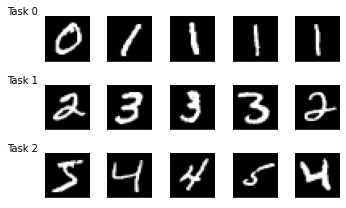

In [ ]:
# tasks to use
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

task_data = []
task_data_with_overlap = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]
  
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))
  task_data_with_overlap.append((x_train_task, t_train_task - (i * 2),
                                 x_test_task, t_test_task - (i * 2)))

# Display tasks
def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")
    # np.vectorize(lambda ax:ax.axis('off'))(axs[sample]);
    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])

n_tasks, samples = 3, 5
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 3))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data[task][0], samples)
plt.tight_layout()

We will first explore continual learning and forgetting using single-head, then use multiple-heads.

In [ ]:
# A basic CNN net
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
    
  def forward(self, x):
      x = F.relu(F.max_pool2d(self.conv1(x), 2))
      x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
      x = x.view(-1, 320)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, training=self.training)
      x = self.fc2(x)
      return x

In [ ]:
def train(model, device, x_train, t_train, optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    return test_loss, 100. * correct / len(t_test)

We will the functions above to train on task 1 and fine-tune on task 2 and see how that affect the performance.

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
x_train_1, t_train_1, x_test_1, t_test_1 = task_data[0]
x_train_2, t_train_2, x_test_2, t_test_2 = task_data[1]

print('Training on Task 1')
train(model, device, x_train_1, t_train_1, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')

print('------------')
print('Training on Task 2')
train(model, device, x_train_2, t_train_2, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')
loss, acc = test(model, device, x_test_2, t_test_2)
print(f'Testing on Task 2: loss -> {loss}, acc -> {acc}')

Training on Task 1
Testing on Task 1: loss -> 1.4395034614946014e-05, acc -> 99.81087470449172
------------
Training on Task 2
Testing on Task 1: loss -> 0.08939847562893627, acc -> 0.0
Testing on Task 2: loss -> 0.00032378461697192665, acc -> 96.91478942213516


**Continual Learning via Rehearsel:**

As we can see the progress we achivied on Task #1 is lost once we fine-tuned to Task #2. One way to remedy that is to keep a portion of the old data to replay with the current task so the network doesn't forget about older data. An ideal senario is keeping all the old data, this is similar to tranditional supervised learning. Usually keeping and retraining on all the previous data is expernsive, so keeping a limited number of the old data is more practicle.

In the next section we will use the rehearsing technique and compare it to fine-tunning with no rehearsing at all, which we call Naive.

In [ ]:
# We will use this function to shuffle the union of old data with the new task data.
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

In [ ]:
# we can use this function to train the model on all tasks for a percentage of 
# old data to rehearse. 0% means naive with expected catastrophic forgetting
def train_singlehead(past_examples_percentage=0, epochs=15):
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  accs_fine_grid = []
  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data[i]

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)
    train(model, device, x_train, t_train, optimizer, epochs)

    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data[j]
      _, test_acc = test(model, device, x_test, t_test)
      accs_subset.append(test_acc)
    
    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))

    accs_fine_grid.append(accs_subset)

  return accs_fine_grid



In [ ]:
accs_naive = train_singlehead() # naive: 0%
accs_rehearsal_all = train_singlehead(1) # regural supervised fashion: 100% 
accs_rehearsal_5 = train_singlehead(0.05) # 5%, about 100 example per task

Text(0.5, 24.0, 'Task Number')

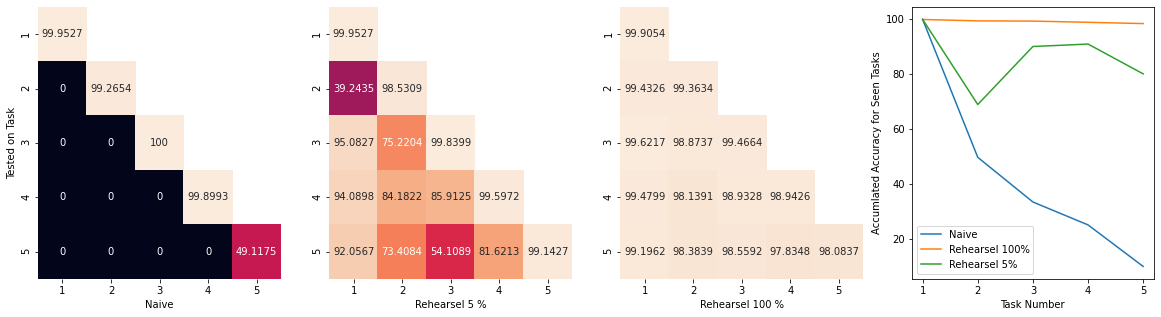

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
accs_fine_grid = np.array(accs_naive)
nan_mask = np.isnan(accs_naive)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Trained on Task')
# fig.text(0.42, 0, 'Tested on Task', ha='center')
axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('Rehearsel 5 %')
axes[2].set_xlabel('Rehearsel 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))
# axes[3].set_xticks([1, 2, 3, 4, 5])
axes[3].legend(['Naive', 'Rehearsel 100%', 'Rehearsel 5%'])
axes[3].set_ylabel('Accumlated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')

In the above graph, we saw the difference of adding 5% (~50 example per class) on the perfromance. Despite not being perfect it's defiently a step forward from totally ignoring previous data or kaeepin and retraining on all data.

In the next section we will try to reproduce what we have done with the single-head setting with multi-head setting. We will create a `BaseNet` that holds the common part to be fine-tunned and a `HeadNet` which holds the unique part for every task and takes the common part as an input. At test there will be an oracle that informs us of the task of each data-point, we smulate 



In [ ]:
class BaseNet(nn.Module):
  def __init__(self):
    super(BaseNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc = nn.Linear(320, 50)
    
  def forward(self, x):
      x = F.relu(F.max_pool2d(self.conv1(x), 2))
      x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
      x = x.view(-1, 320)
      x = F.relu(self.fc(x))
      x = F.dropout(x, training=self.training)
      return x

class HeadNet(nn.Module):
  def __init__(self, base_net):
    super(HeadNet, self).__init__()
    self.base_net = base_net
    self.fc = nn.Linear(50, 2)

  def forward(self, x):
    x = self.base_net.forward(x)
    x = self.fc(x)
    return x

In [ ]:
def train_multihead(past_examples_percentage=0, epochs=10):
  base = BaseNet().to(device)
  heads = []

  accs_fine_grid = []

  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data_with_overlap[i]
    model = HeadNet(base).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    heads.append(model)

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data_with_overlap[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

    train(model, device, x_train, t_train, optimizer, epochs)
    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data_with_overlap[j]
      _, test_acc = test(heads[j], device, x_test, t_test)
      accs_subset.append(test_acc)

    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))
    
    accs_fine_grid.append(accs_subset)

  return accs_fine_grid


In [ ]:
accs_naive = train_multihead(epochs=10)
accs_rehearsal_all = train_multihead(1, epochs=10)
accs_rehearsal_5 = train_multihead(0.05, epochs=10)

Text(0.5, 24.0, 'Task Number')

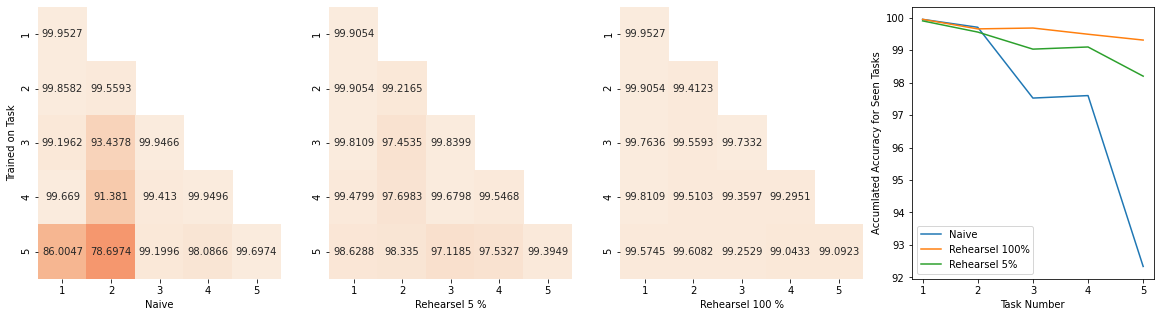

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
accs_fine_grid = np.array(accs_fine_grid)

nan_mask = np.isnan(accs_fine_grid)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Trained on Task')
# fig.text(0.42, 0, 'Tested on Task', ha='center')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('Rehearsel 5 %')
axes[2].set_xlabel('Rehearsel 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))

axes[3].legend(['Naive', 'Rehearsel 100%', 'Rehearsel 5%'])
axes[3].set_ylabel('Accumlated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')
